# Installs & Imports

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#To get the dataset from drive
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir dataset
!unzip gdrive/MyDrive/NLP_dataset.zip -d dataset

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
mkdir: cannot create directory ‘dataset’: File exists
Archive:  gdrive/MyDrive/NLP_dataset.zip
replace dataset/cleaned_dataset.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook as tqdm
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.transform
import argparse
from PIL import Image
import matplotlib.image as mpimg
from IPython import display
from torchtext.vocab import Vectors, GloVe
from scipy import misc
import torch
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
import os
import pickle
from collections import Counter
import torch.utils.data as data
from torchvision import transforms

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("using", device)

using cpu


# Preprocess images and captions

In [4]:
class Vocabulary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(path, count):
    with open(path, 'r') as f:
        dataset_json = json.load(f)

    dataset_json = dataset_json[:count]

    vocab = Vocabulary()
    vocab.add_word('<pad>') # 0
    vocab.add_word('<start>') # 1
    vocab.add_word('<end>') # 2
    vocab.add_word('<unk>') # 3

    for sample in dataset_json:
        caption = sample['caption']
        tokens = nltk.tokenize.word_tokenize(caption)
        for t in tokens:
            vocab.add_word(t)

    return vocab

In [5]:
caption_path = "dataset/cleaned_dataset.json"
vocab_path = "gdrive/MyDrive/vocab.pkl"
vocab = build_vocab(caption_path, 500)
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

In [6]:
print(len(vocab))

1718


In [7]:
def resize_image(image):
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = width - left
        top = 0
        bottom = height
    else:
        top = (height - width) / 2
        bottom = height - top
        left = 0
        right = width
    image = image.crop((left, top, right, bottom))
    image = image.resize([224, 224], Image.ANTIALIAS)
    return image

def prepocess_image(caption_path):
    with open(caption_path, 'r') as f:
        dataset_json = json.load(f)
    dataset_len = len(dataset_json)
    dataset_ids = [*range(dataset_len)]
    image_paths = ['dataset/images/{0:09d}.jpg'.format(id) for id in dataset_ids]
    resized_paths = ['gdrive/MyDrive/resized/{0:09d}.jpg'.format(id) for id in dataset_ids]

    resized_folder = 'gdrive/MyDrive/resized'
    if not os.path.exists(resized_folder):
        os.makedirs(resized_folder)

        counter = 0
        for img_path, resized_path in zip(image_paths, resized_paths):
            with Image.open(img_path) as image:
                image = resize_image(image)
                image.save(resized_path)
            if(counter%1000 == 0):
                print("finished", counter)
            counter += 1

In [ ]:
# prepocess_image(caption_path)

finished 0
finished 1000
finished 2000
finished 3000
finished 4000
finished 5000
finished 6000
finished 7000
finished 8000
finished 9000
finished 10000
finished 11000
finished 12000


# DataLoader

In [8]:
class DataLoader(data.Dataset):
    def __init__(self, root, dataset, vocab, transform=None):

        self.root = root
        self.dataset = dataset
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        vocab = self.vocab
        caption = self.dataset[index]['caption']
        path = '{0:09d}.jpg'.format(index)
        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        tokens = nltk.tokenize.word_tokenize(str(caption))
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.dataset)

def collate_fn(data):
    data.sort(key=lambda  x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    return images, targets, lengths

def get_loader(vocab, batch_size, count):
    root = 'gdrive/MyDrive/resized'
    with open('dataset/cleaned_dataset.json', 'r') as f:
        dataset_json = json.load(f)  
    dataset_json = dataset_json[:count]

    # resnet transformation/normalization
    transform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),
                            (0.229, 0.224, 0.225))])

    dataset = DataLoader(root=root, dataset=dataset_json, vocab=vocab, transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1,
                                              collate_fn=collate_fn)
    return data_loader

In [9]:
PAD = 0
START = 1
END = 2
UNK = 3

grad_clip = 5.
num_epochs = 1
batch_size = 32
decoder_lr = 0.0004

# Load vocabulary wrapper
with open('gdrive/MyDrive/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)
print(len(vocab))

# load data
train_loader = get_loader(vocab, batch_size, 500)
test_loader = get_loader(vocab, 5, 20)

1718


#Build Model

In [10]:
# Load pre-trained tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

for name, param in list(model.named_parameters())[:-79]: 
    param.requires_grad = False

In [11]:
# enocder
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        resnet = models.resnet101(pretrained=True)
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        self.adaptive_pool = nn.AdaptiveAvgPool2d((14, 14))

    def forward(self, images):
        out = self.adaptive_pool(self.resnet(images))
        # batch_size, img size, imgs size, 2048
        out = out.permute(0, 2, 3, 1)
        return out

In [12]:
# decoder
class Decoder(nn.Module):

    def __init__(self, vocab_size):
        super(Decoder, self).__init__()
        self.encoder_dim = 2048
        self.attention_dim = 512
        self.embed_dim = 768
            
        self.decoder_dim = 512
        self.vocab_size = vocab_size
        self.dropout = 0.5
        
        # soft attention
        self.enc_att = nn.Linear(2048, 512)
        self.dec_att = nn.Linear(512, 512)
        self.att = nn.Linear(512, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

        # decoder layers
        self.dropout = nn.Dropout(p=self.dropout)
        self.decode_step = nn.LSTMCell(self.embed_dim + self.encoder_dim, self.decoder_dim, bias=True)
        self.h_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.c_lin = nn.Linear(self.encoder_dim, self.decoder_dim)
        self.f_beta = nn.Linear(self.decoder_dim, self.encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(self.decoder_dim, self.vocab_size)

        # init variables
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)            

    def forward(self, encoder_out, encoded_captions, caption_lengths):    
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size
        dec_len = [x-1 for x in caption_lengths]
        max_dec_len = int(max(dec_len).item())

        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)
        num_pixels = encoder_out.size(1)

        embeddings = []
        for cap_idx in  encoded_captions:
            
            # padd caption to correct size
            while len(cap_idx) < max_dec_len:
                cap_idx.append(PAD)
                
            cap = ' '.join([vocab.idx2word[word_idx.item()] for word_idx in cap_idx])
            cap = u'[CLS] '+cap
            
            tokenized_cap = tokenizer.tokenize(cap)                
            indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_cap)
            tokens_tensor = torch.tensor([indexed_tokens])

            encoded_layers, _ = model(tokens_tensor)

            bert_embedding = encoded_layers[11].squeeze(0)
            
            split_cap = cap.split()
            tokens_embedding = []
            j = 0

            for full_token in split_cap:
                curr_token = ''
                x = 0
                for i,_ in enumerate(tokenized_cap[1:]): # disregard CLS
                    token = tokenized_cap[i+j]
                    piece_embedding = bert_embedding[i+j]
                    
                    # full token
                    if token == full_token and curr_token == '' :
                        tokens_embedding.append(piece_embedding)
                        j += 1
                        break
                    else: # partial token
                        x += 1
                        
                        if curr_token == '':
                            tokens_embedding.append(piece_embedding)
                            curr_token += token.replace('#', '')
                        else:
                            tokens_embedding[-1] = torch.add(tokens_embedding[-1], piece_embedding)
                            curr_token += token.replace('#', '')
                            
                            if curr_token == full_token: # end of partial
                                j += x
                                break                            
            
                            
            cap_embedding = torch.stack(tokens_embedding)

            embeddings.append(cap_embedding)
            
        embeddings = torch.stack(embeddings)

        # init hidden state
        avg_enc_out = encoder_out.mean(dim=1)
        h = self.h_lin(avg_enc_out)
        c = self.c_lin(avg_enc_out)

        predictions = torch.zeros(batch_size, max_dec_len, vocab_size)
        alphas = torch.zeros(batch_size, max_dec_len, num_pixels)

        for t in range(max_dec_len):
            batch_size_t = sum([l > t for l in dec_len ])
            
            # soft-attention
            enc_att = self.enc_att(encoder_out[:batch_size_t])
            dec_att = self.dec_att(h[:batch_size_t])
            att = self.att(self.relu(enc_att + dec_att.unsqueeze(1))).squeeze(2)
            alpha = self.softmax(att)
            attention_weighted_encoding = (encoder_out[:batch_size_t] * alpha.unsqueeze(2)).sum(dim=1)
        
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            attention_weighted_encoding = gate * attention_weighted_encoding
            
            batch_embeds = embeddings[:batch_size_t, t, :]  
            cat_val = torch.cat([batch_embeds.double(), attention_weighted_encoding.double()], dim=1)
            
            h, c = self.decode_step(cat_val.float(),(h[:batch_size_t].float(), c[:batch_size_t].float()))
            preds = self.fc(self.dropout(h))
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha
            
        # preds, sorted capts, dec lens, attention wieghts
        return predictions, encoded_captions, dec_len, alphas

In [13]:
# initialize a new model
# decoder = Decoder(vocab_size=len(vocab)).to(device)
# decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)

# encoder = Encoder().to(device)

# load model
encoder = Encoder().to(device)
encoder_checkpoint = torch.load('./gdrive/MyDrive/checkpoints/encoder')
encoder.load_state_dict(encoder_checkpoint['model_state_dict'])

decoder = Decoder(vocab_size=len(vocab)).to(device)
decoder_optimizer = torch.optim.Adam(params=decoder.parameters(),lr=decoder_lr)
decoder_checkpoint = torch.load('./gdrive/MyDrive/checkpoints/decoder')
decoder.load_state_dict(decoder_checkpoint['model_state_dict'])
decoder_optimizer.load_state_dict(decoder_checkpoint['optimizer_state_dict'])

In [14]:
class loss_obj(object):
    def __init__(self):
        self.avg = 0.
        self.sum = 0.
        self.count = 0.

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [15]:
criterion = nn.CrossEntropyLoss().to(device)

# Train

In [16]:
def train():
    print("Started training...")
    for epoch in tqdm(range(num_epochs)):
        decoder.train()
        encoder.train()

        losses = loss_obj()
        num_batches = len(train_loader)

        for i, (imgs, caps, caplens) in enumerate(tqdm(train_loader)):
            imgs = torch.FloatTensor(imgs).to(device)
            # caps = torch.FloatTensor(caps).to(device)
            caps = caps.to(device)
            caplens = torch.FloatTensor(caplens).to(device)
            imgs = encoder(imgs)

            scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
            scores = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]

            targets = caps_sorted[:, 1:]
            targets = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

            loss = criterion(scores, targets)
            loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

            decoder_optimizer.zero_grad()
            loss.backward()

            # grad_clip decoder
            for group in decoder_optimizer.param_groups:
                for param in group['params']:
                    if param.grad is not None:
                        param.grad.data.clamp_(-grad_clip, grad_clip)

            decoder_optimizer.step()

            losses.update(loss.item(), sum(decode_lengths))
            print('Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))

            if i % 5 == 0:
                print('Batch '+str(i)+'/'+str(num_batches)+' loss:'+str(losses.avg))
                
                 # adjust learning rate (create condition for this)
                for param_group in decoder_optimizer.param_groups:
                    param_group['lr'] = param_group['lr'] * 0.5

                print('saving model...')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': decoder.state_dict(),
                    'optimizer_state_dict': decoder_optimizer.state_dict(),
                    'loss': loss,
                    }, './gdrive/MyDrive/checkpoints/decoder')

                torch.save({
                    'epoch': epoch,
                    'model_state_dict': encoder.state_dict(),
                    'loss': loss,
                    }, './gdrive/MyDrive/checkpoints/encoder')

                print('model saved')
        
        print('Epoch Loss:'+str(losses.avg))

    print("Completed training...") 

In [17]:
train()

Started training...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/16 [00:00<?, ?it/s]

Batch 0/16 loss:tensor(7.0080)
Batch 0/16 loss:tensor(7.0080)
saving model...
model saved
Batch 1/16 loss:tensor(6.9140)
Batch 2/16 loss:tensor(6.9299)
Batch 3/16 loss:tensor(6.9744)
Batch 4/16 loss:tensor(7.0085)
Batch 5/16 loss:tensor(7.0224)
Batch 5/16 loss:tensor(7.0224)
saving model...
model saved
Batch 6/16 loss:tensor(7.0407)
Batch 7/16 loss:tensor(7.0298)
Batch 8/16 loss:tensor(7.0320)
Batch 9/16 loss:tensor(7.0439)
Batch 10/16 loss:tensor(7.0457)
Batch 10/16 loss:tensor(7.0457)
saving model...
model saved
Batch 11/16 loss:tensor(7.0553)
Batch 12/16 loss:tensor(7.0618)
Batch 13/16 loss:tensor(7.0686)
Batch 14/16 loss:tensor(7.0676)
Batch 15/16 loss:tensor(7.0686)
Batch 15/16 loss:tensor(7.0686)
saving model...
model saved
Epoch Loss:tensor(7.0686)
Completed training...


# Generate Captions

In [23]:
%matplotlib inline

def print_sample(hypotheses,references,imgs, alphas, k):
    img_dim = 500 # 14*24
    
    hyp_sentence = []
    for word_idx in hypotheses[k]:
        hyp_sentence.append(vocab.idx2word[word_idx])
    
    ref_sentence = []
    for word_idx in references[k]:
        ref_sentence.append(vocab.idx2word[word_idx])
        
    img = imgs[0][k] 

    plt.imshow(img)
    plt.axis('off')
    plt.show()
        
    print('Hypotheses: '+" ".join(hyp_sentence))
    print('References: '+" ".join(ref_sentence))

In [20]:
references = [] 
test_references = []
hypotheses = [] 
all_imgs = []
all_alphas = []

def validate():
    print("Started validation...")
    decoder.eval()
    encoder.eval()
    
    losses = loss_obj()

    num_batches = len(test_loader)
    # Batches
    for i, (imgs, caps, caplens) in enumerate(tqdm(test_loader)):

        imgs = torch.FloatTensor(imgs).to(device)
        # caps = torch.FloatTensor(caps).to(device)
        caps = caps.to(device)
        caplens = torch.FloatTensor(caplens).to(device)

        imgs_jpg = imgs.numpy() 
        imgs_jpg = np.swapaxes(np.swapaxes(imgs_jpg, 1, 3), 1, 2)
        # Forward prop.
        imgs = encoder(imgs)
        scores, caps_sorted, decode_lengths, alphas = decoder(imgs, caps, caplens)
        targets = caps_sorted[:, 1:]

        # Remove timesteps that we didn't decode at, or are pads
        scores_packed = pack_padded_sequence(scores, decode_lengths, batch_first=True)[0]
        targets_packed = pack_padded_sequence(targets, decode_lengths, batch_first=True)[0]

        # Calculate loss
        loss = criterion(scores_packed, targets_packed)
        loss += ((1. - alphas.sum(dim=1)) ** 2).mean()

        losses.update(loss.item(), sum(decode_lengths))

        # print("target shape", targets.shape)
         # References
        for j in range(targets.shape[0]):
            img_caps = targets[j].tolist() # validation dataset only has 1 unique caption per img
            clean_cap = [w for w in img_caps if w not in [PAD, START, END]]  # remove pad, start, and end
            img_captions = list(map(lambda c: clean_cap,img_caps))
            test_references.append(clean_cap)
            references.append(img_captions)
            # all_imgs.append(imgs_jpg[j])
            # all_imgs.append(imgs[j])
        

        # Hypotheses
        _, preds = torch.max(scores, dim=2)
        preds = preds.tolist()
        temp_preds = list()
        for j, p in enumerate(preds):
            pred = p[:int(decode_lengths[j].item())]
            pred = [w for w in pred if w not in [PAD, START, END]]
            temp_preds.append(pred)  # remove pads, start, and end
        preds = temp_preds
        hypotheses.extend(preds)
        
        all_alphas.append(alphas)
        # print("img jpg", len(imgs_jpg))
        all_imgs.append(imgs_jpg)            


    bleu = corpus_bleu(references, hypotheses)
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0, 1, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0, 0, 1, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0, 0, 0, 1))

    print("Validation loss: "+str(losses.avg))
    print("BLEU: "+str(bleu))
    print("BLEU-1: "+str(bleu_1))
    print("BLEU-2: "+str(bleu_2))
    print("BLEU-3: "+str(bleu_3))
    print("BLEU-4: "+str(bleu_4))

In [21]:
validate()

Started validation...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


  0%|          | 0/4 [00:00<?, ?it/s]

Validation loss: tensor(6.8279)
BLEU: 2.2822147006616005e-155
BLEU-1: 0.18904109589041093
BLEU-2: 0.00289855072463768
BLEU-3: 2.2250738585072626e-308
BLEU-4: 2.2250738585072626e-308


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


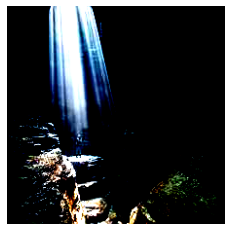

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hypotheses: a a the the the the the the the the the the the the the the the the the the the the the the the the . . . . the the
References: a man stands on a rock pillar in the middle of an underground cave a large ray of light casts down on him from an opening in the earth above .


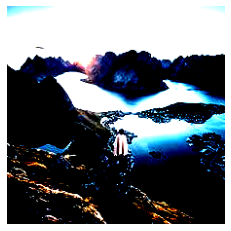

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hypotheses: a a a a a the the the the the the the the the the the the the the the the the the
References: a hiker with a blanket draped over their shoulders looks out over a bay surrounded by steep cliffs and mountain peaks .


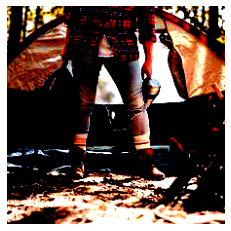

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Hypotheses: a a a the the the the . . . . . . . . . . . . . .
References: a badass camper stands in front of a tent ready to haul ass shop trees and take nature on .


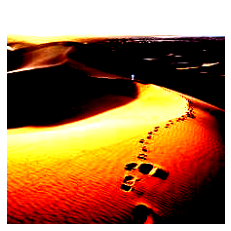

Hypotheses: a a a the the the the the the the the the the the the . . .
References: footsteps leave imprints in a sand dune as a person takes a journey across the horizon .


In [24]:
for i in range(len(all_imgs)):
    print_sample(hypotheses, test_references, all_imgs, all_alphas, i)